In [1]:
from __future__ import print_function, division
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline

from halotools.sim_manager import CachedHaloCatalog, UserSuppliedHaloCatalog
from halotools.empirical_models import HodModelFactory

from halotools.empirical_models import TrivialPhaseSpace, ZuMandelbaum15Cens, ZuMandelbaum15Sats, \
                                        Leauthaud11Cens, Leauthaud11Sats, Zheng07Cens, Zheng07Sats, \
                                        NFWPhaseSpace, SubhaloPhaseSpace

from halotools.mock_observables import tpcf
from halotools.mock_observables.ia_correlations import ee_3d, ed_3d

from halotools.empirical_models.ia_models.ia_model_components import CentralAlignment, RandomAlignment, RadialSatelliteAlignment, SubhaloAlignment
from halotools.empirical_models.ia_models.ia_strength_models import RadialSatelliteAlignmentStrength

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Eliminate halos with 0 for halo_axisA_x(,y,z)
def mask_bad_halocat(halocat):
    bad_mask = (halocat.halo_table["halo_axisA_x"] == 0) & (halocat.halo_table["halo_axisA_y"] == 0) & (halocat.halo_table["halo_axisA_z"] == 0)
    bad_mask = bad_mask ^ np.ones(len(bad_mask), dtype=bool)
    halocat._halo_table = halocat.halo_table[ bad_mask ]

In [93]:
def create_model(cen_mu, sat_mu, selected_halocat):
    cens_occ_model = Zheng07Cens()
    cens_prof_model = TrivialPhaseSpace()
    cens_orientation = CentralAlignment(central_alignment_strength=cen_mu)
    sats_occ_model = Zheng07Sats()
    prof_args = ("satellites", np.logspace(10.5, 15.2, 15))
    sats_prof_model = SubhaloPhaseSpace(*prof_args)
    sats_prof_model = NFWPhaseSpace(conc_mass_model="dutton_maccio14")
    sats_orientation = RadialSatelliteAlignment(satellite_alignment_strength=sat_mu, halocat=selected_halocat)

    model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                     centrals_profile = cens_prof_model,
                                     satellites_occupation = sats_occ_model,
                                     satellites_profile = sats_prof_model,
                                     centrals_orientation = cens_orientation,
                                     satellites_orientation = sats_orientation,
                                     model_feature_calling_sequence = (
                                     'centrals_occupation',
                                     'centrals_profile',
                                     'satellites_occupation',
                                     'satellites_profile',
                                     'centrals_orientation',
                                     'satellites_orientation')
                                    )
    
    return model_instance

In [4]:
def correlate(model, rbins, halocat):
    gal_table = model.mock.galaxy_table
    coords = np.array( [ gal_table["x"], gal_table["y"], gal_table["z"] ] ).T
    orientations = np.array( [ gal_table["galaxy_axisA_x"], gal_table["galaxy_axisA_y"], gal_table["galaxy_axisA_z"] ] ).T
    
    xi = tpcf(coords, rbins, period = halocat.Lbox)
    omega = ed_3d(coords, orientations, coords, rbins, period=halocat.Lbox)
    eta = ee_3d(coords, orientations, coords, orientations, rbins, period=halocat.Lbox)
    
    return xi, omega, eta

In [82]:
seed=132358712
cen_mu = 1.0
sat_mu = 1.0

In [83]:
rbins = np.logspace(-1,1.2,21)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

# Load Table

In [5]:
import pickle
f_name = "TNG100-1_99_non-reduced_galaxy_shapes_multi_scale_1024_MLP_only_cent.pkl"
with open(f_name, 'rb') as file:
    data = pickle.load(file)

In [28]:
data

gal_id,a,b,c,av_x,av_y,av_z,bv_x,bv_y,bv_z,cv_x,cv_y,cv_z,tid_av_x_0.1_1024,tid_av_y_0.1_1024,tid_av_z_0.1_1024,tid_bv_x_0.1_1024,tid_bv_y_0.1_1024,tid_bv_z_0.1_1024,tid_cv_x_0.1_1024,tid_cv_y_0.1_1024,tid_cv_z_0.1_1024,tid_a_0.1_1024,tid_b_0.1_1024,tid_c_0.1_1024,tid_av_x_0.5_1024,tid_av_y_0.5_1024,tid_av_z_0.5_1024,tid_bv_x_0.5_1024,tid_bv_y_0.5_1024,tid_bv_z_0.5_1024,tid_cv_x_0.5_1024,tid_cv_y_0.5_1024,tid_cv_z_0.5_1024,tid_a_0.5_1024,tid_b_0.5_1024,tid_c_0.5_1024,tid_av_x_1.0_1024,tid_av_y_1.0_1024,tid_av_z_1.0_1024,tid_bv_x_1.0_1024,tid_bv_y_1.0_1024,tid_bv_z_1.0_1024,tid_cv_x_1.0_1024,tid_cv_y_1.0_1024,tid_cv_z_1.0_1024,tid_a_1.0_1024,tid_b_1.0_1024,tid_c_1.0_1024,tid_av_x_2.0_1024,tid_av_y_2.0_1024,tid_av_z_2.0_1024,tid_bv_x_2.0_1024,tid_bv_y_2.0_1024,tid_bv_z_2.0_1024,tid_cv_x_2.0_1024,tid_cv_y_2.0_1024,tid_cv_z_2.0_1024,tid_a_2.0_1024,tid_b_2.0_1024,tid_c_2.0_1024,mass,GroupID,tot_mass,dm_mass,central_bool,group_mass,group_x,group_y,group_z,gal_pos_x,gal_pos_y,gal_pos_z,dm_av_x,dm_av_y,dm_av_z,dm_bv_x,dm_bv_y,dm_bv_z,dm_cv_x,dm_cv_y,dm_cv_z,dm_a,dm_b,dm_c,mlp_av_x,mlp_av_y,mlp_av_z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,0.24562844247483243,0.11233008826530698,0.09435347356932028,0.15057356009311798,-0.36432524666271543,0.9190183445639349,-0.6040801058750838,0.7019725376704176,0.37725559246020707,0.7825693762771655,0.611965416507098,0.11438312949234405,0.8275753855705261,0.5501617810833461,-0.11153932645318682,-0.4364806852752775,0.7555949692944677,0.4884269175204382,0.3529923768186143,-0.355525325415916,0.8654467776217399,1054.244087225318,991.9027130436707,668.0261137005616,-0.9183833599090576,0.33972494317589014,0.20287679547321114,0.33534699111399274,0.9403888675675559,-0.05666721544068841,-0.2100343464963115,0.015991896046057438,-0.9775632115381181,59.10935058615099,55.377614125575626,37.975054282341716,0.9371282458305359,0.1784244452709745,-0.29992566920893826,-0.2053100234179685,0.9768323454844315,-0.06038512316371721,0.2822029128212493,0.11816634946180396,0.9520494891811419,13.122050507836377,11.700347539646893,9.282237732126015,-0.8248880505561829,0.33217499988277654,0.4574051124728157,0.5063412900419841,0.7939398479662237,0.3365679958195495,-0.2513526714837356,0.5092340201363678,-0.8231054290148635,2.5250096232145673,2.341083724345102,1.7858375325765965,251.0163116455078,0.0,27477.935546875,23325.619140625,1.0,38878.03515625,849.0914306640625,26326.99609375,18306.93359375,0.8490914106369019,26.326995849609375,18.306934356689453,0.20913785733198287,-0.2376266091458571,0.9485752217175131,-0.0291868731156354,0.9680772186306577,0.24894703293283385,0.9774505015950008,0.07975019369363229,-0.19552601754628252,0.7422561814889702,0.380580342545896,0.2953753041796042,-0.8295962810516357,0.51895672082901,0.5298088788986206
1.0,0.08088470650058953,0.04497213832247513,0.03777383880658522,-0.9840750455762398,-0.006859759853817557,0.17762108086843106,0.07866214907516236,0.8792771126813137,0.46977018361927686,-0.15940066178344028,0.4762611707976621,-0.8647350612837673,-0.25285616517066956,-0.542943046543665,-0.8007974784346137,-0.0015899779481896464,-0.8274600252025045,0.5615223759228073,0.9675025711735737,-0.14325765215776112,-0.20836511193280413,340.0297044488053,304.0921077455601,251.82406385313607,-0.43189844489097595,-0.6954925306839556,-0.5742419895334245,-0.7976

# Table Columns

In [50]:
from halotools.utils import crossmatch

In [64]:
gal = np.array([1,2,3,4,5,6,7,8])
gro = np.array([1,1,1,1,2,2,2,3])
cen = [True, False, False, False, True, False, False,False]

gro_unique = np.array([ el for el in set(gro)])

In [65]:
inds1, inds2 = crossmatch(gal,gro_unique)

In [66]:
a[inds1]

array([1, 2, 3])

In [67]:
b[inds2]

array([1, 1, 1])

In [68]:
def get_halo_upid(gal_id, group_id, is_central):
    upids = -np.ones( len(gal_id) )
    cen_mask = is_central.astype(bool)
    
    group_dict = { group_id[cen_mask][i] : gal_id[cen_mask][i] for i in range(sum(cen_mask)) }
    sat_upids = np.array( [ group_dict[group] if group in group_dict else -1 for group in group_id[~cen_mask] ] )
    upids[~cen_mask] = sat_upids
    
    return upids

In [94]:
labels = {
    'halo_id' : "gal_id",
    # 'halo_upid' : "?", #Crossmatch group_id central with gal_id
    # 'halo_mvir' : "?", # Scale dm mass to within bolplanck ranges
    'halo_axisA_z' : "dm_av_x",
    'halo_axisA_x' : "dm_av_y",
    'halo_axisA_y' : "dm_av_z",
    # 'halo_vx' : "?", # Fake
    # 'halo_vy' : "?", # Fake
    # 'halo_vz' : "?", # Fake
    'halo_x' : "gal_pos_x",
    'halo_y' : "gal_pos_y",
    'halo_z' : "gal_pos_z",
    # 'halo_mvir_host_halo' : "?", # See above
    # 'halo_hostid' : "?", # Upid
    # 'halo_mpeak' : "?", #all 0's
    # 'halo_rvir' : "?", # from mvir
    # 'halo_tidal_force' : "?"
}

In [95]:
upids = get_halo_upid( data["gal_id"], data["GroupID"], data["central_bool"] )
mvirs = ( ( data["dm_mass"] - min(data["dm_mass"]) )/( max(data["dm_mass"]) - min(data["dm_mass"]) ) ) * 1268999400000000.0

others = {
    'halo_upid' : upids,
    'halo_vx' : np.random.uniform(-1,1,len(data)),
    'halo_vy' : np.random.uniform(-1,1,len(data)),
    'halo_vz' : np.random.uniform(-1,1,len(data)),
    'halo_hostid' : data["gal_id"],
    'halo_mvir' : mvirs,
    'halo_rvir' : pow(mvirs,1.0/3.0),
}

In [96]:
kwargs = {}

for label in labels:
    kwargs[label] = data[labels[label]]
    
for label in others:
    kwargs[label] = others[label]

In [97]:
particle_mass = 0.000599968882709879e10
Lbox = np.array( [ 110.7, 110.7, 110.7 ] )
redshift = 0

In [98]:
halocat = UserSuppliedHaloCatalog(particle_mass=particle_mass, Lbox=Lbox, redshift=redshift, **kwargs)

In [99]:
model = create_model(1.0, 1.0, halocat)

model.populate_mock(halocat, seed=seed)

In [100]:
halocat.halo_table

halo_id,halo_axisA_z,halo_axisA_x,halo_axisA_y,halo_x,halo_y,halo_z,halo_upid,halo_vx,halo_vy,halo_vz,halo_hostid,halo_mvir,halo_rvir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0,0.20913785733198287,-0.2376266091458571,0.9485752217175131,0.8490914106369019,26.326995849609375,18.306934356689453,-1.0,-0.8137503780214808,0.13968357234784712,-0.3081770076617296,0.0,1247108641678629.2,107638.61381124168
1.0,-0.894172344445321,-0.431108424887396,-0.12083602285852724,0.10647333413362503,24.63332176208496,16.90055274963379,0.0,0.3221392223821897,-0.768449217652676,-0.6459432633105313,1.0,170237746942347.88,55422.39478960528
2.0,-0.44998482120148936,0.5216721585493953,-0.7248253718535784,0.8531123399734497,26.72574806213379,17.510679244995117,0.0,0.9660657488265201,0.04456712200633017,0.7207396953485268,2.0,38397815135772.586,33736.666743733236
3.0,0.07192887265149081,-0.602036263783214,0.7952223427249978,0.24545502662658691,26.517372131347656,15.888749122619629,0.0,0.0784550431434603,0.45717691498951973,-0.5193727468042477,3.0,16601426921907.434,25510.274942651533
4.0,-0.7731495452799411,-0.025394237333196023,-0.6337151673612411,0.7687843441963196,26.51828956604004,15.530523300170898,0.0,0.3588227288560688,-0.6407162412064589,0.9485175592180595,4.0,16405373749638.867,25409.456535085727
5.0,0.3918429756654348,0.3654932744319969,0.8443185114437765,1.4265923500061035,26.341442108154297,19.04120445251465,0.0,-0.32917223120519346,-0.06131899623860537,-0.3775924360496139,5.0,15124473879714.236,24730.150465046532
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142296.0,-0.5187560454913621,-0.8333328644552721,-0.19091490849311613,24.606287002563477,9.583114624023438,12.3409423828125,-1.0,0.7012797391402421,0.8626269245765545,-0.8059987529481707,1142296.0,11136617605.795555,2233.1493508409762
1143364.0,-0.6276019349036428,-0.2107692271881861,0.7494612359393235,40.5776252746582,66.83486938476562,41.01032257080078,-1.0,0.4167910359047702,-0.30027074162354705,0.2294284664854329,1143364.0,5649400834.000387,1781.014532741936


In [104]:
len(data)

50737

In [101]:
xi, omega, eta = correlate(model, rbins, halocat)

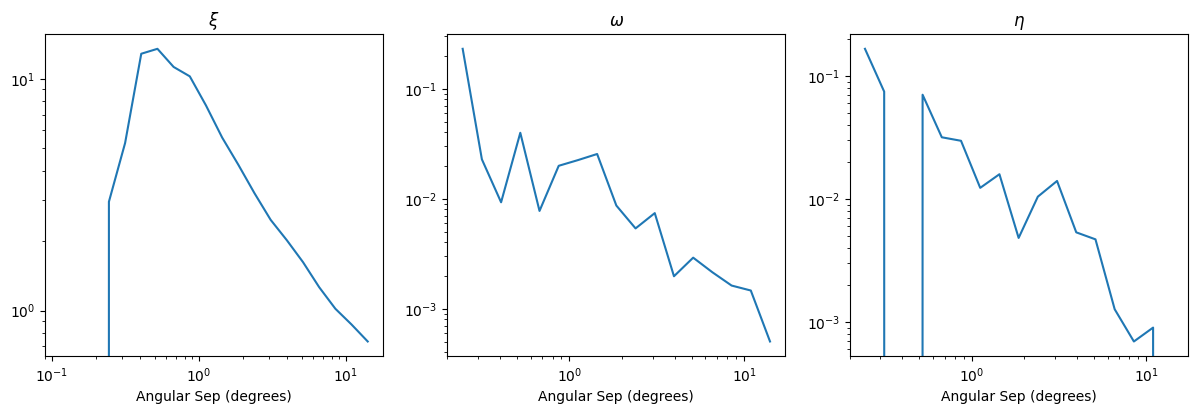

In [105]:
# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot data in the first subplot
axes[0].plot(rbin_centers, xi)
axes[0].set_title(r'$\xi$')

# Plot data in the second subplot
axes[1].plot(rbin_centers, abs(omega))
axes[1].set_title(r'$\omega$')

# Plot data in the third subplot
axes[2].plot(rbin_centers, eta)
axes[2].set_title(r'$\eta$')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
for ax in axes:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("Angular Sep (degrees)")
plt.show()